# DTSA 5511 Deep Learning - Predicting AI Generated Text

As AI becomes more prevelant and usable with the release and continued innovations of Generative AIs like ChatGPT and Bard, more and more people are tunring to these Generative AIs to create content. While creating content like pictures, music, or text, using Generative AIs is not inherintly negative, creating AI content without citation can be misleading or even plagiarism.

Essays are used in acedemia as a way to test student's knowledge of the topic or topics, as well as a way to further research and learning in a specifc area. Students who use Generative AIs to write eassays for them not only miss out on additional learning and skill building from researching and writing an essay, for many schools and educational institutions, using an AI without citation is considered plagiarism and could lead to or disciplinary actions or even explusion. Additionally, while Generative AIs can write essays, they are not perfect and can sometimes include incorrect information or fail to answer the prompt provided. 

While some cases of Generative AI plagerism is obvious, individual teachers may not be able to scrutinize every single essay a stuent writes. For this reason, it is important to develop tools to detect AI generated text. This project will use the dataset from the [LLM-Detect AI Generated Text Kaggle Competition](https://www.kaggle.com/competitions/llm-detect-ai-generated-text) to attempt to accurately detect AI generated essays. In contrast to the competition, we will instead focus on predicting AI vs non-AI essays from a smaller portion of the provided text and compare results to traditional Machine Learning Models (supervised and unsupervised).

***Data Citation:***
```
The Learning Agency Lab. (2023, October 31). LLM - detect AI generated text. LLM - Detect AI Generated Text. https://www.kaggle.com/competitions/llm-detect-ai-generated-text 
```

In [1]:
# Libraries
import pandas as pd
import numpy as np

## String manipulation
import string
import random
import re

## NLP
import spacy
nlp = spacy.load("en_core_web_sm")
import tensorflow_text as text 

## Math
import math

# Data Visualization
import matplotlib.pyplot as plt

# Time
import time

# Sklearn Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Sklearn Models
from sklearn.decomposition import NMF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Deep Learning
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras import utils
import tensorflow_hub as hub
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Dense, TextVectorization
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Exploration

In [2]:
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
# final_test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')

print('Train Essays:', len(train_essays))
# print('Test Essays:', len(final_test_essays))
print('Train Prompts:', len(train_prompts))

Train Essays: 1378
Train Prompts: 2


In [3]:
train_essays

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


There are 1,378 essays from two prompts. We can now look at the distribution of these essays, as well as some example texts and general features.

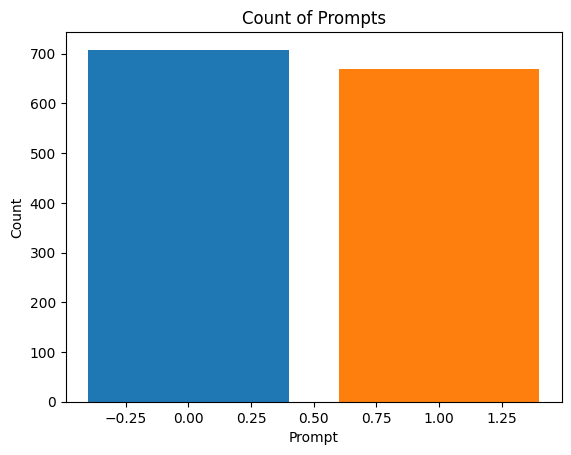

In [4]:
df = pd.DataFrame(train_essays['prompt_id'].value_counts()).reset_index()
fig, ax = plt.subplots()
ax.bar(df['prompt_id'],df['count'], color=['tab:blue','tab:orange'])
ax.set_ylabel('Count')
ax.set_xlabel('Prompt')
ax.set_title('Count of Prompts')
plt.show()

The prompts look fairly evenly distributed.

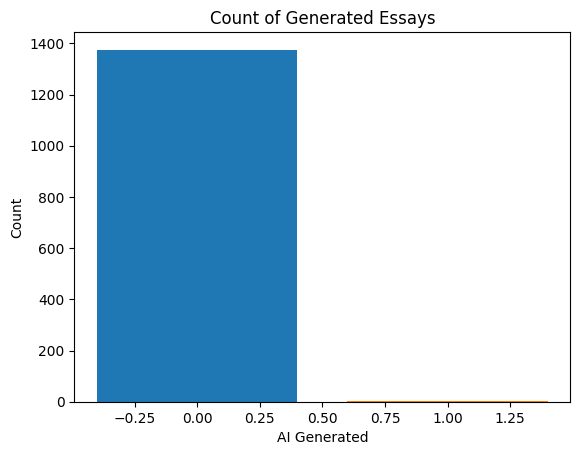

In [5]:
df = pd.DataFrame(train_essays['generated'].value_counts()).reset_index()
fig, ax = plt.subplots()
ax.bar(df['generated'],df['count'], color=['tab:blue','tab:orange'])
ax.set_ylabel('Count')
ax.set_xlabel('AI Generated')
ax.set_title('Count of Generated Essays')
plt.show()

Unfortunatley, in the original dataset, there are not many AI Generated essays. We will need to either replicate these generated entries or 'create' new entries based on the provided prompts. Before doing this, we can look at some essay texts.

In [6]:
take = 3
for i in range(take):
    print('Essay ',i,':')
    print(train_essays[train_essays['generated'] == 0].reset_index().loc[i]['text'])
    print('')

Essay  0 :
Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go.

Looking at some of these essays, we can see there are a range of formats these essays take. Some utilize quotes, some describe statistics, most have multiple paragraphs, although the actual paragraph number vary.

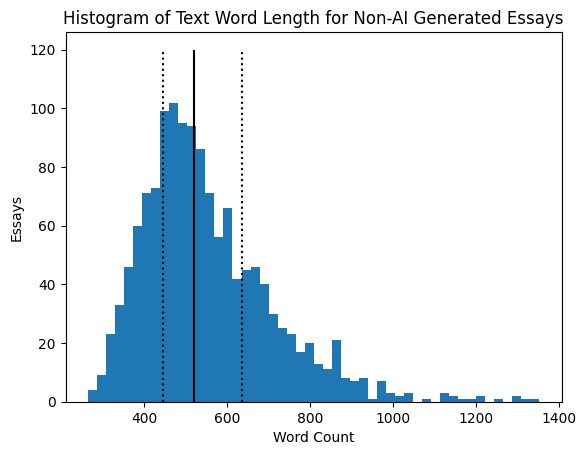

In [7]:
df = train_essays[train_essays['generated'] == 0].copy()
df['Word Count'] = df['text'].apply(lambda x: len(x.split(sep=' ')))
fig, ax = plt.subplots()
ax.hist(df['Word Count'], bins=50)
ax.set_ylabel('Essays')
ax.set_xlabel('Word Count')
ax.set_title('Histogram of Text Word Length for Non-AI Generated Essays')
ax.vlines(df['Word Count'].quantile(0.5), 0, 120, color='black')
ax.vlines(df['Word Count'].quantile(0.25), 0, 120, color='black', linestyle='dotted')
ax.vlines(df['Word Count'].quantile(0.75), 0, 120, color='black', linestyle='dotted')
fig.show()

In [8]:
print('Median: ', df['Word Count'].quantile(0.5))
print('Q1: ', df['Word Count'].quantile(0.25))
print('Q3: ', df['Word Count'].quantile(0.75))

Median:  521.0
Q1:  444.5
Q3:  635.0


The real essays seem to vary in length. On average, the essays are around 500 words, but can be as long as 1,400 words or as short as a less than 200 words.

We can now take a look at the three generated essays.

In [9]:
take = 3
for i in range(take):
    print('Essay ',i,':')
    print(train_essays[train_essays['generated'] == 1].reset_index().loc[i]['text'])
    print('')

Essay  0 :
This essay will analyze, discuss and prove one reason in favor of keeping the Electoral College in the United States for its presidential elections. One of the reasons to keep the electoral college is that it is better for smaller, more rural states to have more influence as opposed to larger metropolitan areas that have large populations. The electors from these states are granted two votes each. Those from larger, more populated areas are granted just one vote each. Smaller states tend to hold significant power because their two votes for president and vice president add up more than the votes of larger states that have many electors. This is because of the split of the electoral votes. Some argue that electors are not bound to vote for the candidate who won the most votes nationally. They do not have to vote for their own state's nominee unless their state has a winner take all system. However, there are states that have adopted laws that force their electors to vote for 

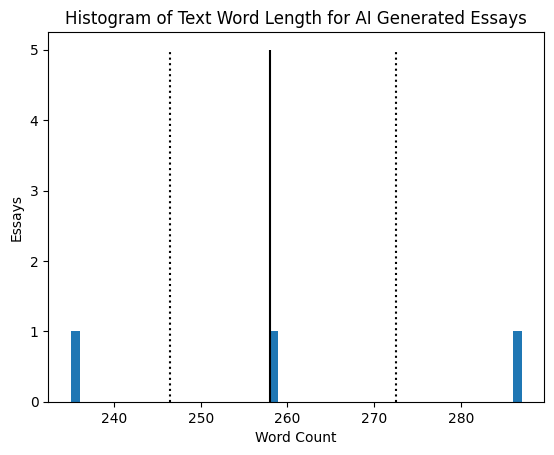

In [10]:
df = train_essays[train_essays['generated'] == 1].copy()
df['Word Count'] = df['text'].apply(lambda x: len(x.split(sep=' ')))
fig, ax = plt.subplots()
ax.hist(df['Word Count'], bins=50)
ax.set_ylabel('Essays')
ax.set_xlabel('Word Count')
ax.set_title('Histogram of Text Word Length for AI Generated Essays')
ax.vlines(df['Word Count'].quantile(0.5), 0, 5, color='black')
ax.vlines(df['Word Count'].quantile(0.25), 0, 5, color='black', linestyle='dotted')
ax.vlines(df['Word Count'].quantile(0.75), 0, 5, color='black', linestyle='dotted')
fig.show()

In [11]:
print('Median: ', df['Word Count'].quantile(0.5))
print('Q1: ', df['Word Count'].quantile(0.25))
print('Q3: ', df['Word Count'].quantile(0.75))

Median:  258.0
Q1:  246.5
Q3:  272.5


Compared to the real essays, the AI generated essays are much shorter and do not seem to use direct quotations or utilize multiple paragraphs. However, the above conclusions and statistics may not be the cases if we add in additional known AI generated essays.

# Data Generation for AI Generation Esssays
Due to the inbalance of AI and Non-AI generated essays, we can import some additional AI generated essays from the [LLM: Mistral-7B Instruct texts](https://www.kaggle.com/datasets/carlmcbrideellis/llm-mistral-7b-instruct-texts?select=Mistral7B_CME_v7.csv), which includes essays for prompts 'Car-free cities' and 'Does the electoral college work,' both of which match the original prompt minus the provided texts.

***Data Citation:***
```
Ellis, C. M. (2023, November 29). LLM: Mistral-7B instruct texts. LLM: Mistral-7B Instruct texts. https://www.kaggle.com/datasets/carlmcbrideellis/llm-mistral-7b-instruct-texts?select=Mistral7B_CME_v7.csv 
```

In [12]:
add_ai_essays = pd.read_csv('/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v7.csv')
add_ai_essays[['prompt_name','prompt_id']].groupby('prompt_name', as_index=False).max('prompt_id')

,prompt_name,prompt_id
0,A Cowboy Who Rode the Waves,4
1,Car-free cities,2
2,Does the electoral college work?,12
3,Driverless cars,11
4,Exploring Venus,6
5,Facial action coding system,7
6,The Face on Mars,8


In [13]:
add_ai_essays = add_ai_essays[(add_ai_essays['prompt_id'] == 2) | (add_ai_essays['prompt_id'] == 12)]
print('New Prompt 0 (Cars):', len(add_ai_essays[add_ai_essays['prompt_id']==2]))
print('New Prompt 1 (Electoral College):', len(add_ai_essays[add_ai_essays['prompt_id']==12]))

New Prompt 0 (Cars): 700
New Prompt 1 (Electoral College): 700


Adding these AI generated essays will functionally double our training dataset!

In [14]:
train_essays_full = train_essays.copy()
add_ai_essays['id'] = None
add_ai_essays = add_ai_essays.drop(columns={'prompt_name'})
add_ai_essays['prompt_id'] = add_ai_essays['prompt_id'].map({2: 0, 12: 1})
train_essays_full = pd.concat([train_essays_full,add_ai_essays])
train_essays_full = train_essays_full.reset_index().drop(columns={'index'})

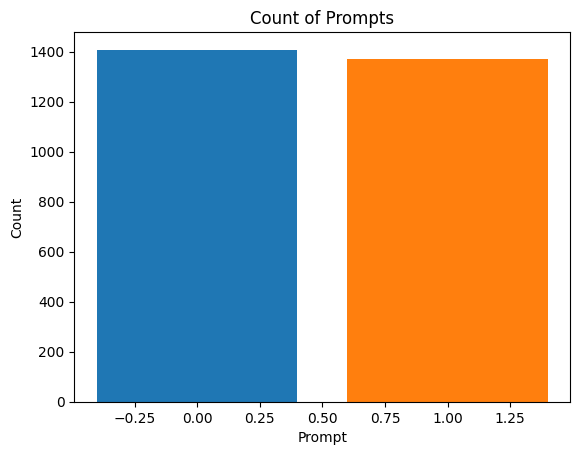

In [15]:
df = pd.DataFrame(train_essays_full['prompt_id'].value_counts()).reset_index()
fig, ax = plt.subplots()
ax.bar(df['prompt_id'],df['count'], color=['tab:blue','tab:orange'])
ax.set_ylabel('Count')
ax.set_xlabel('Prompt')
ax.set_title('Count of Prompts')
plt.show()

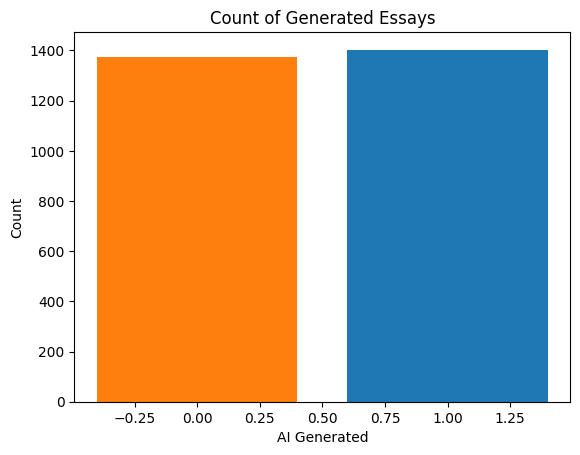

In [16]:
df = pd.DataFrame(train_essays_full['generated'].value_counts()).reset_index()
fig, ax = plt.subplots()
ax.bar(df['generated'],df['count'], color=['tab:blue','tab:orange'])
ax.set_ylabel('Count')
ax.set_xlabel('AI Generated')
ax.set_title('Count of Generated Essays')
plt.show()

We can see from the plots above that the balance of essays for each prompt remains balanced, but the overall number of AI generated essays is now at the same level of the non-AI generated essays.

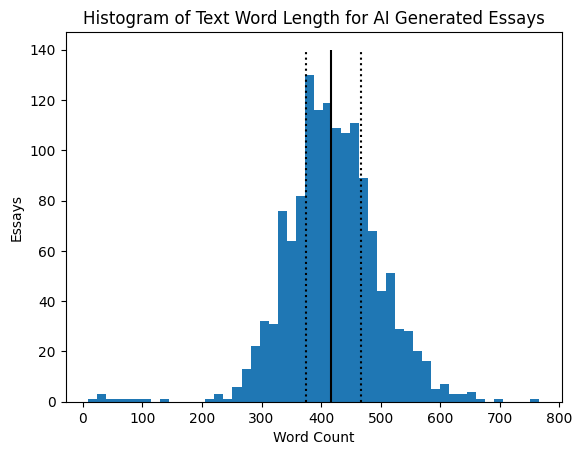

In [17]:
df = train_essays_full[train_essays_full['generated'] == 1].copy()
df['Word Count'] = df['text'].apply(lambda x: len(x.split(sep=' ')))
fig, ax = plt.subplots()
ax.hist(df['Word Count'], bins=50)
ax.set_ylabel('Essays')
ax.set_xlabel('Word Count')
ax.set_title('Histogram of Text Word Length for AI Generated Essays')
ax.vlines(df['Word Count'].quantile(0.5), 0, 140, color='black')
ax.vlines(df['Word Count'].quantile(0.25), 0, 140, color='black', linestyle='dotted')
ax.vlines(df['Word Count'].quantile(0.75), 0, 140, color='black', linestyle='dotted')
fig.show()

In [18]:
print('Median: ', df['Word Count'].quantile(0.5))
print('Q1: ', df['Word Count'].quantile(0.25))
print('Q3: ', df['Word Count'].quantile(0.75))

Median:  417.0
Q1:  374.0
Q3:  467.0


Looking at the word count plots and statistics, overall, the AI generated essays are still shorter than non-AI generated essays.

# Data Cleaning and Text Processing

Like other Natural Language Processing projects, we must first clean the text before model ingestion. This project in particular must clean the data before ingestion to ensure the first N words chosen for the model are important. Here is the raw text before cleaning:

In [19]:
print(train_essays_full.loc[1:2]['text'].values)

['Transportation is a large necessity in most countries worldwide. With no doubt, cars, buses, and other means of transportation make going from place to place easier and faster. However there\'s always a negative pollution. Although mobile transportation are a huge part of daily lives, we are endangering the Earth with harmful greenhouse gases, which could be suppressed.\n\nA small suburb community in Germany called Vauban, has started a "carfree" lifestyle. In this city, markets and stores are placed nearby homes, instead of being located by farend highways. Although Vauban is not completely carfree, 70% of Vauban families do not own cars Even a large 57% of families stated to have sold their cars to move to Vauban. Some families have even said to be less stressed depending on car transportation. Cars are responsible for about 12% of greenhouse gases, and can even be up to 50% in some carintensive areas in the United States.\n\nAnother insight to reduced car zones brings Paris\' inci

We will now create a function of multiple functions that will remove text features that do not make sense to be parsed, including apostrophes, extra spaces, punctuation, and stop words within the nlp model.

In [20]:
def remove_newline(text):
    return re.sub('\\n', '', text)

def remove_ss(text):
    return re.sub('\\\'s', '', text)

def remove_ap(text):
    return re.sub('\\\'', '', text)

def remove_period(text):
    text = re.sub('\. ', ' ', text)
    return re.sub('\.', ' ', text)

def remove_char(text):
    return re.sub('[^a-zA-Z\d\s:]', '', text)

def remove_words(text):
    doc = nlp(text)
    n_text = [word.text for word in doc if (word not in nlp.Defaults.stop_words)] #word.text forces back to string
    return ' '.join(n_text) #forces back to full text

def clean_text(text):
    text = remove_newline(text)
    text = remove_ss(text)
    text = remove_ap(text)
    text = remove_period(text)
    text = remove_char(text)
    text = remove_words(text)
    parts = text.split()[:250]
    return ' '.join(parts)

In [21]:
train_essays_full['text_clean'] = train_essays_full['text'].apply(clean_text)

In [22]:
print(train_essays_full.loc[1:2]['text_clean'].values)

['Transportation is a large necessity in most countries worldwide With no doubt cars buses and other means of transportation make going from place to place easier and faster However there always a negative pollution Although mobile transportation are a huge part of daily lives we are endangering the Earth with harmful greenhouse gases which could be suppressed A small suburb community in Germany called Vauban has started a carfree lifestyle In this city markets and stores are placed nearby homes instead of being located by farend highways Although Vauban is not completely carfree 70 of Vauban families do not own cars Even a large 57 of families stated to have sold their cars to move to Vauban Some families have even said to be less stressed depending on car transportation Cars are responsible for about 12 of greenhouse gases and can even be up to 50 in some carintensive areas in the United States Another insight to reduced car zones brings Paris incident with smog Paris officials creat

The clean text now has no '\'s, no single appostrophes, or punctuaion characters. The text is now at most 250 cleaned words long.

# Train Test Split
We will now split the dataset into training and testing sets. We will split the data into 80% Training and 20% Testing.

In [23]:
X_train, X_test = train_test_split(train_essays_full[['generated','text_clean']], test_size=0.2, stratify = train_essays_full['generated'], random_state =101)
print('Train Length:', len(X_train),'\t Percent AI Generated: %.2f' %(len(X_train[X_train['generated']==1])/len(X_train)*100),'%')
print('Test Length:', len(X_test),'\t Percent AI Generated: %.2f' %(len(X_train[X_train['generated']==1])/len(X_train)*100),'%')
print('Percent Split: %.2f' %(len(X_test)/(len(X_train)+len(X_test))), '%')

# Force to Tensor Datasets
tensor_train_text = tf.convert_to_tensor(X_train['text_clean'].values)
X_train_t = tf.data.Dataset.from_tensor_slices((tensor_train_text, X_train['generated']))

tensor_test_text = tf.convert_to_tensor(X_test['text_clean'].values)
X_test_t = tf.data.Dataset.from_tensor_slices((tensor_test_text, X_test['generated']))

BATCH_SIZE = 64

train_dataset = X_train_t.shuffle(len(X_train_t), seed=101).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = X_test_t.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Train Length: 2222 	 Percent AI Generated: 50.50 %
Test Length: 556 	 Percent AI Generated: 50.50 %
Percent Split: 0.20 %


# Text Vectorization
We can use [this tutorial](https://www.tensorflow.org/tutorials/keras/text_classification#prepare_the_dataset_for_training) to leverage tensorflow functions to further clean and vectorize text. We will set the maximum length to be 250, which will just take the first 250 words in the essay.

In [24]:
max_features = 10000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='tf_idf',
    pad_to_max_tokens=True
)

train_text = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Modeling

We can now build the model. We will utilize tensorflow to vectorize text withint the Neural Network. We can start with a bidirectional sequential neural network using our custom text vectorization.

In [25]:
def plot_func(history):
    history_dict = history.history
    history_dict.keys()


    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()

In [26]:
first_model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(max_features,128),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

first_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer='adam')
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 10000)             1         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 10000, 128)        1280000   
                                                                 
 bidirectional (Bidirection  (None, 64)                41216     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [27]:
history = first_model.fit(x=train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
35/35 [==============================] - 34s 603ms/step - loss: 0.6919 - accuracy: 0.5131 - val_loss: 0.6904 - val_accuracy: 0.4946
Epoch 2/10
35/35 [==============================] - 18s 521ms/step - loss: 0.6885 - accuracy: 0.5419 - val_loss: 0.6651 - val_accuracy: 0.6655
Epoch 3/10
35/35 [==============================] - 18s 525ms/step - loss: 0.5872 - accuracy: 0.7147 - val_loss: 0.5155 - val_accuracy: 0.7626
Epoch 4/10
35/35 [==============================] - 18s 529ms/step - loss: 0.4594 - accuracy: 0.8083 - val_loss: 0.3930 - val_accuracy: 0.8309
Epoch 5/10
35/35 [==============================] - 18s 518ms/step - loss: 0.3927 - accuracy: 0.8492 - val_loss: 0.4548 - val_accuracy: 0.7788
Epoch 6/10
35/35 [==============================] - 18s 519ms/step - loss: 0.3815 - accuracy: 0.8461 - val_loss: 0.3756 - val_accuracy: 0.8417
Epoch 7/10
35/35 [==============================] - 18s 523ms/step - loss: 0.3504 - accuracy: 0.8650 - val_loss: 0.3753 - val_accuracy: 0.8471

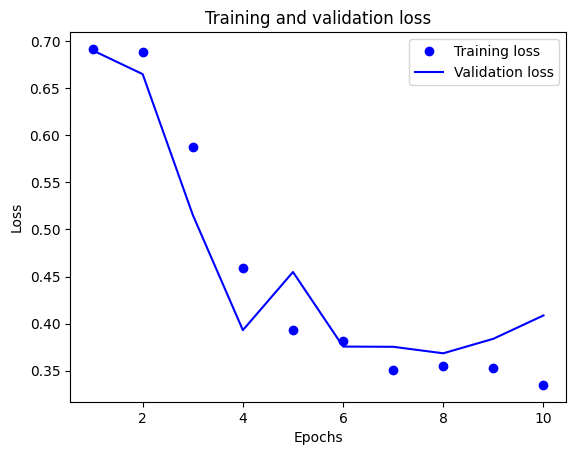

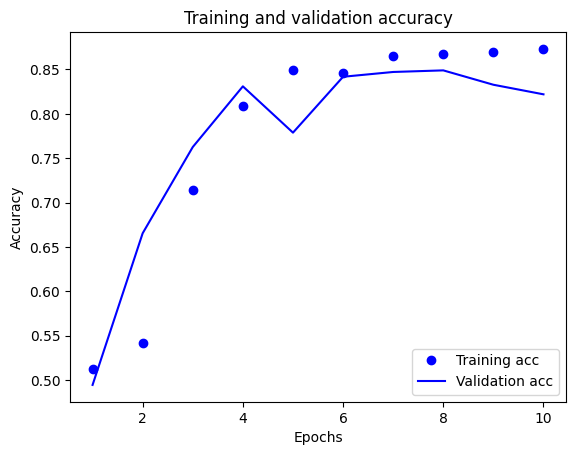

In [28]:
plot_func(history)

It looks like the model performed the best at 9 epochs. We did not save any history, so we will visualize the results at 10 epochs.

In [29]:
first_pred = first_model.predict(test_dataset)

9/9 [==============================] - 3s 210ms/step


In [30]:
def cm_visual(pred, test_dataset):
    test_y = []
    for i in list(test_dataset):
        for j in i[1]:
            test_y.append(int(j))
    # turning into 1/0 predictions       
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0 
    pred = pred.reshape(1,-1)[0]
    print('Length:', len(test_y))

    cm = confusion_matrix(test_y, pred)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    print('Accuracy: %.2f' %(accuracy_score(test_y, pred)))
    print('F1: %.2f' %(f1_score(test_y, pred)))
    print('Precision: %.2f' %(precision_score(test_y, pred)))
    print('Recall: %.2f' %(recall_score(test_y, pred)))

Length: 556
Accuracy: 0.82
F1: 0.81
Precision: 0.87
Recall: 0.77


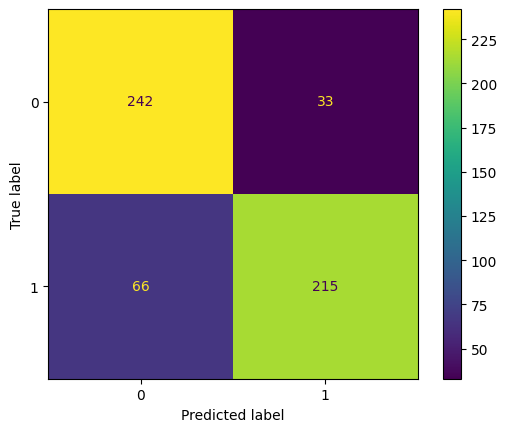

In [31]:
cm_visual(first_pred, test_dataset)

Looking at the confusion matrix, the model did worse in instances where the essay was AI generated than when (false negative) than when the essay was not AI generated (false positives). Neither 'false' classification is worse than another; on the one hand, accusing a non-AI generated paper as AI generated is not great and might cause frustration from the student who wrote the paper. On the other hand, not catching AI generated papers is a disservice to the students who wrote a paper.

For our second model, we will use BERT, a pre-trained bi-directional large language model, to encode the text.

In [32]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-128-a-2/versions/2",
    trainable=True)

In [33]:
text_input = layers.Input(shape=(), dtype=tf.string)
encoder_inputs = preprocessor(text_input)
outputs = encoder(encoder_inputs)
pooled_output = outputs['pooled_output']
sequence_output = outputs['sequence_output']
dense1 = layers.Dense(128, activation='relu')(pooled_output)
dropout1 = layers.Dropout(0.7, name='dropout1')(pooled_output)
dense2 = layers.Dense(64, activation='relu')(dropout1)
dropout = layers.Dropout(0.5, name='dropout2')(dense2)
dense3 = layers.Dense(16, activation='relu')(dropout)
dropout = layers.Dropout(0.5, name='dropout3')(dropout)
dense_out = layers.Dense(1, activation='sigmoid', name='output')(dropout)

second_model = tf.keras.Model(inputs=text_input, outputs=dense_out)
second_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer='adam')
second_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [34]:
history = second_model.fit(x=train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
35/35 [==============================] - 33s 508ms/step - loss: 0.7735 - accuracy: 0.5914 - val_loss: 0.1065 - val_accuracy: 0.9766
Epoch 2/10
35/35 [==============================] - 17s 484ms/step - loss: 0.1944 - accuracy: 0.9374 - val_loss: 0.0869 - val_accuracy: 0.9856
Epoch 3/10
35/35 [==============================] - 16s 457ms/step - loss: 0.1384 - accuracy: 0.9680 - val_loss: 0.1080 - val_accuracy: 0.9784
Epoch 4/10
35/35 [==============================] - 14s 395ms/step - loss: 0.0859 - accuracy: 0.9802 - val_loss: 0.1010 - val_accuracy: 0.9766
Epoch 5/10
35/35 [==============================] - 15s 428ms/step - loss: 0.0535 - accuracy: 0.9910 - val_loss: 0.0421 - val_accuracy: 0.9856
Epoch 6/10
35/35 [==============================] - 15s 418ms/step - loss: 0.0239 - accuracy: 0.9964 - val_loss: 0.0778 - val_accuracy: 0.9892
Epoch 7/10
35/35 [==============================] - 14s 410ms/step - loss: 0.0498 - accuracy: 0.9896 - val_loss: 0.0571 - val_accuracy: 0.9820

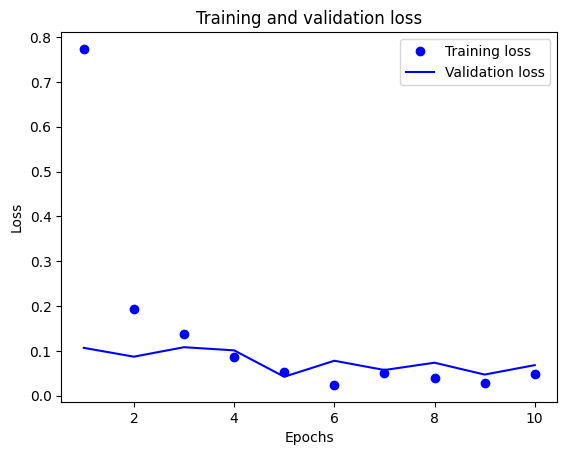

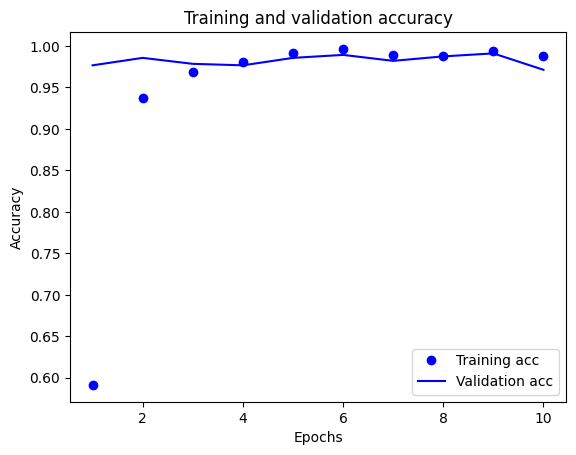

In [35]:
plot_func(history)

Wow! Using BERT is a large improvement from using the untrained NLP before! The second model is also much faster to train than the first model, likely because the NLP model is already bi-directionally trained. We can now investigate the resulting confusion matrix.

9/9 [==============================] - 2s 204ms/step
Length: 556
Accuracy: 0.97
F1: 0.97
Precision: 0.95
Recall: 0.99


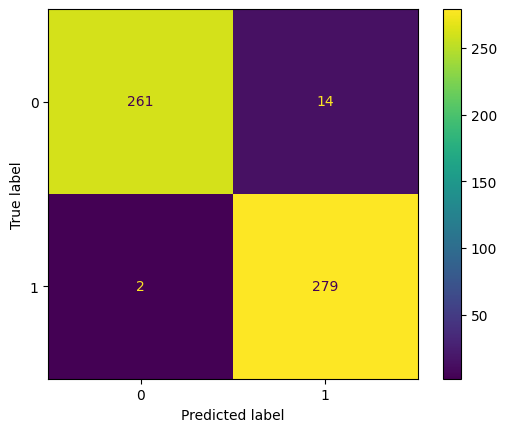

In [36]:
second_pred = second_model.predict(test_dataset)
cm_visual(second_pred, test_dataset)

Overall, it looks like the BERT model is performing much better than the first model. This model has more false positives (not an AI-generated model, but predicted as such) than false negatives (AI generated model, but predicted as non-AI generated).

# Supervised Models

We can quickly train a few supervised models to compare preformance. We will use the first deep learning model, which uses tf-idf to vectorize sentences.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier

In [66]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')

train_x2 = tfidf.fit_transform(X_train['text_clean'])
test_x2 = tfidf.transform(X_test['text_clean'])

train_y2 = X_train['generated'].values
test_y2 = X_test['generated'].values

In [67]:
svc_model = LinearSVC()
knn_model = KNeighborsClassifier()
sgd_model = SGDClassifier()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
rg_model = RidgeClassifier()
lg_model = LogisticRegression()

svc_model.fit(train_x2,train_y2)
knn_model.fit(train_x2,train_y2)
sgd_model.fit(train_x2,train_y2)
dt_model.fit(train_x2,train_y2)
rf_model.fit(train_x2,train_y2)
rg_model.fit(train_x2,train_y2)
lg_model.fit(train_x2,train_y2)

svc_predict = svc_model.predict(test_x2)
knn_predict =  knn_model.predict(test_x2)
sgd_predict =  sgd_model.predict(test_x2)
dt_predict = dt_model.predict(test_x2)
rf_predict = rf_model.predict(test_x2)
rg_predict = rg_model.predict(test_x2)
lg_predict = lg_model.predict(test_x2)

print('SVC Accuracy: %.3f' %(accuracy_score(test_y2, svc_predict)))
print('KNN Accuracy: %.3f' %(accuracy_score(test_y2, knn_predict)))
print('SGD Accuracy: %.3f' %(accuracy_score(test_y2, sgd_predict)))
print('DT Accuracy: %.3f' %(accuracy_score(test_y2, dt_predict)))
print('RF Accuracy: %.3f' %(accuracy_score(test_y2, rf_predict)))
print('RG Accuracy: %.3f' %(accuracy_score(test_y2, rg_predict)))
print('LG Accuracy: %.3f' %(accuracy_score(test_y2, rg_predict)))

SVC Accuracy: 0.996
KNN Accuracy: 0.986
SGD Accuracy: 0.996
DT Accuracy: 0.971
RF Accuracy: 0.996
RG Accuracy: 0.996
LG Accuracy: 0.996


We can easily see that the supervised learning models did extremely well, and fit and predicted the results in much less time than the deep learning models.

# Conclusions

Overall, this project was fairly successful. While the results cannot be tested on the hidden test_essays, most of the models performed very well. Out of the two models tested, the model using BERT performed much better than the model using tf-idf. The supervised models all performed very well, and much better than the deep learning tf-idf model.


This project was very interesting to complete. My skills in using tensorflow and creating deep learning networks have improved. Being able to shift over to use a different compute resource more targeted to training deep learning models has been helpful and spead up the overall time needed to run the entire notebook and cut training times of neural networks by half. Further improvements could be made by taking a larger number of words per essay. Additionally, saving models based on the best metrics would help ensure the best model is being used.